## CRYPTOCURRENCY PRICE ANALYSIS

## 🔄 Data Collection via CoinCommon adn CoinGecko API

We fetch historical data for 200 cryptocurrency using CoinCompare Api and CoinGecko API for the past 30 days starting from Aug 7th 2025. The fields include:

- Coin
- Price (USD)
- Market Cap
- Volume
- Circulating Supply
- Timestamp
- high
- low
- open
- coingecko id

In [1]:
import requests
import pandas as pd
import time
from tqdm import tqdm

# 🔑 Add your CryptoCompare API Key
CRYPTOCOMPARE_API_KEY = '6a0c8d6eae56e53c0fac03c0bcd15dbb3025463f03e27a0e37bc285e145197f1'

# Endpoints
COINGECKO_MARKET_URL = "https://api.coingecko.com/api/v3/coins/markets"
CRYPTOCOMPARE_URL = "https://min-api.cryptocompare.com/data/v2/histohour"

# Step 1: Get top 250 coins from CoinGecko
def get_top_250_coins():
    params = {
        'vs_currency': 'usd',
        'order': 'market_cap_desc',
        'per_page': 250,
        'page': 1,
        'sparkline': False
    }
    response = requests.get(COINGECKO_MARKET_URL, params=params)
    response.raise_for_status()
    coins = response.json()
    coin_list = []
    for coin in coins:
        coin_list.append({
            'id': coin['id'],
            'symbol': coin['symbol'].upper(),
            'name': coin['name'],
            'market_cap': coin.get('market_cap'),
            'circulating_supply': coin.get('circulating_supply')
        })
    return pd.DataFrame(coin_list)

# Step 2: Get 30 days (720 hours) of hourly data from CryptoCompare
def get_cryptocompare_data(symbol, target='USD', hours=720):
    params = {
        'fsym': symbol,
        'tsym': target,
        'limit': hours,
        'aggregate': 1,
        'api_key': CRYPTOCOMPARE_API_KEY
    }
    response = requests.get(CRYPTOCOMPARE_URL, params=params)
    if response.status_code != 200:
        return None

    data = response.json()
    if data['Response'] != 'Success':
        return None

    df = pd.DataFrame(data['Data']['Data'])
    df['timestamp'] = pd.to_datetime(df['time'], unit='s')
    df['coin'] = symbol
    df.rename(columns={
        'volumeto': 'volume',
        'close': 'price',
        'high': 'high',
        'low': 'low',
        'open': 'open'
    }, inplace=True)
    return df[['timestamp', 'coin', 'price', 'volume', 'high', 'low', 'open']]

# Step 3: Merge data sources
def main():
    gecko_df = get_top_250_coins()
    print(f"✅ Loaded top {len(gecko_df)} coins from CoinGecko")

    final_data = []

    for _, row in tqdm(gecko_df.iterrows(), total=len(gecko_df), desc="Scraping CryptoCompare"):
        symbol = row['symbol']
        coin_id = row['id']
        market_cap = row['market_cap']
        circ_supply = row['circulating_supply']

        cc_data = get_cryptocompare_data(symbol)
        if cc_data is None:
            print(f"[!] Skipping {symbol} (missing data)")
            continue

        cc_data['market_cap'] = market_cap
        cc_data['circulating_supply'] = circ_supply
        cc_data['coingecko_id'] = coin_id

        final_data.append(cc_data)
        time.sleep(1.2)

    if final_data:
        df_final = pd.concat(final_data, ignore_index=True)
        df_final.to_csv("integrated_crypto_data.csv", index=False)
        print(f"✅ Combined data saved to 'integrated_crypto_data.csv'")
    else:
        print("❌ No data retrieved.")

if __name__ == "__main__":
    main()

Error: 429
[2025-08-03 05:46:22.574104] Fetched 1250 coins and saved to all_crypto_data.csv.
Sleeping for 2 hours...

Stopped by user.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.interpolate import make_interp_spline
import os
from datetime import datetime, timedelta

In [3]:
os.makedirs('comp_analysis', exist_ok=True)
os.makedirs('stability_analysis', exist_ok=True)
os.makedirs('spike_analysis', exist_ok=True)


In [4]:
##  Loading DataSet
csv_path = 'integrated_crypto_data.csv'
df = pd.read_csv(csv_path, parse_dates=['timestamp'], low_memory=False)
df.head()


,timestamp,coin,price,volume,high,low,open,market_cap,circulating_supply,coingecko_id
0,2025-07-08 00:00:00,BTC,108305.41,67560170.77,108538.36,108194.43,108277.16,2288648265385,19902853.0,bitcoin
1,2025-07-08 01:00:00,BTC,107699.44,62062550.87,108305.95,107683.74,108305.41,2288648265385,19902853.0,bitcoin
2,2025-07-08 02:00:00,BTC,107776.22,85347030.06,107946.86,107445.04,107699.44,2288648265385,19902853.0,bitcoin
3,2025-07-08 03:00:00,BTC,107910.16,22980054.52,108010.89,107698.32,107776.22,2288648265385,19902853.0,bitcoin
4,2025-07-08 04:00:00,BTC,108033.87,15964979.03,108033.87,107761.77,107910.16,2288648265385,19902853.0,bitcoin


## DATA CLEANING

In [5]:
# Convert timestamp to datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['date'] = df['timestamp'].dt.date

In [6]:
# identify missing values in price
missin_count = df['price'].isnull
missin_count

<bound method Series.isnull of 0         108305.4100
1         107699.4400
2         107776.2200
3         107910.1600
4         108033.8700
             ...     
144195         0.3031
144196         0.3022
144197         0.3033
144198         0.3032
144199         0.3030
Name: price, Length: 144200, dtype: float64>

In [7]:
#quantify missingness
total_missing = df.isnull().sum()
total_values = df.isnull().count()

percent_missing = total_missing/total_values
percent_missing*100

timestamp             0.0
coin                  0.0
price                 0.0
volume                0.0
high                  0.0
low                   0.0
open                  0.0
market_cap            0.0
circulating_supply    0.0
coingecko_id          0.0
hour                  0.0
date                  0.0
dtype: float64

In [8]:
# Removing extreme outliers
for col in ['price', 'market_cap', 'volume', 'high', 'low', 'open', 'circulating_supply']:
    q_low = df[col].quantile(0.001)
    q_high = df[col].quantile(0.999)
    df = df[(df[col] >= q_low) & (df[col] <= q_high)]
    

In [9]:
print("\n--- Dataset Overview ---")
print(df.info())
print(df.describe())
print(df.head())


--- Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
Index: 143481 entries, 0 to 144199
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           143481 non-null  datetime64[ns]
 1   coin                143481 non-null  object        
 2   price               143481 non-null  float64       
 3   volume              143481 non-null  float64       
 4   high                143481 non-null  float64       
 5   low                 143481 non-null  float64       
 6   open                143481 non-null  float64       
 7   market_cap          143481 non-null  int64         
 8   circulating_supply  143481 non-null  float64       
 9   coingecko_id        143481 non-null  object        
 10  hour                143481 non-null  int32         
 11  date                143481 non-null  object        
dtypes: datetime64[ns](1), float64(6), int32(1), int64(1), object(3)
m

 ##  Temporal and Volatility Analysis

# 1. How does average trading volume and price change over the day (hourly / daily / weekly trend)?

In [10]:
# Compute average daily volume to identify top and bottom coins

daily_vol = df.groupby(['coin', 'date']).agg({'volume': 'sum'}).reset_index()
avg_vol = daily_vol.groupby('coin')['volume'].mean().reset_index(name = 'avg_volume')
avg_vol = avg_vol.sort_values('avg_volume', ascending=False).reset_index(drop = True)

top_5 = avg_vol.head(5)['coin'].tolist()
bottom_5 = avg_vol.tail(5)['coin'].tolist()

In [11]:
# Function to compute best trade

def best_trade_for_coin(df_coin):
    df_coin = df_coin.sort_values('date')
    prices = df_coin['price'].values
    dates = df_coin['date'].astype(str).values
    
    min_price = float('inf')
    min_idx = -1
    best_profit = 0.0
    buy_date = None
    sell_date = None
    
    for i, p in enumerate(prices):
        if p < min_price:
            min_price = p
            min_idx = i
        profit = p - min_price
        if profit > best_profit:
            best_profit = profit
            buy_date = dates[min_idx]
            sell_date = dates[i]
    
    if best_profit <= 0:
        min_i = prices.argmin()
        max_i = prices.argmax()
        buy_date = dates[min_i]
        sell_date = dates[max_i]
        best_profit = prices[max_i] - prices[min_i]
    
    return {
        'coin': df_coin['coin'].iloc[0],
        'buy_date': buy_date,
        'sell_date': sell_date,
        'buy_price': float(min_price),
        'sell_price': float(min_price + best_profit),
        'profit': float(best_profit)
    }

In [12]:
# Compute best trades for top5 and bottom5

def compute_best_trades(coins):
    results = []
    for c in coins:
        dfc = df[df['coin'] == c][['coin','date','price']]
        if dfc.empty:
            continue

        # Get daily average price for each coin
        
        dfc = dfc.groupby(['coin','date']).agg({'price':'mean'}).reset_index()
        res = best_trade_for_coin(dfc)
        results.append(res)
    return pd.DataFrame(results)

top_trades = compute_best_trades(top_5)
bottom_trades = compute_best_trades(bottom_5)

In [13]:
# Create comprehensive visualization

def create_comprehensive_plot(coins, trades_df, group_name):

    # Create figure with subplots
    
    fig = plt.figure(figsize = (16, 12))
    gs = GridSpec(2, 2, figure = fig, height_ratios = [2, 1])
    
    # First subplot: Hourly patterns
    
    ax1 = fig.add_subplot(gs[0, :])
    
    # Filter data for the group
    
    group_data = df[df['coin'].isin(coins)].copy()
    
    # Calculate daily average price for normalization
    
    daily_avg_price = group_data.groupby(['coin', 'date'])['price'].mean().reset_index()
    daily_avg_price = daily_avg_price.rename(columns={'price': 'daily_avg'})
    
    # Merge with original data
    
    group_data = group_data.merge(daily_avg_price, on = ['coin', 'date'])
    
    # Normalize price by daily average
    
    group_data['norm_price'] = group_data['price'] / group_data['daily_avg']
    
    # Aggregate by hour
    
    hourly_data = group_data.groupby('hour').agg({
        'volume': 'mean',
        'norm_price': 'mean'
    }).reset_index()
    
    # Bar plot for volume
    
    sns.barplot( x = 'hour', y = 'volume', data = hourly_data,hue = 'hour', legend = False, color = 'skyblue', alpha = 0.7, ax = ax1)
    ax1.set_xlabel('Hour of Day (24h)', fontsize = 12)
    ax1.set_ylabel('Average Volume (USD)', color = 'darkblue', fontsize = 12)
    ax1.tick_params(axis = 'y', labelcolor = 'darkblue')
    ax1.set_title(f'Hourly Trading Patterns: {group_name} Cryptocurrencies', fontsize = 14)
    
    # Create secondary y-axis for price
    
    ax2 = ax1.twinx()
    
    # Create smooth line for normalized price
    
    x = hourly_data['hour']
    y = hourly_data['norm_price']
    
    # Create smooth curve
    
    if len(x) > 3:
        x_smooth = np.linspace(x.min(), x.max(), 300)
        spl = make_interp_spline(x, y, k=3)
        y_smooth = spl(x_smooth)
        ax2.plot(x_smooth, y_smooth, 'r-', linewidth = 3, label = 'Normalized Price')
    else:
        ax2.plot(x, y, 'ro-', linewidth = 3, label = 'Normalized Price')
    
    ax2.set_ylabel('Price (Normalized to Daily Average)', color = 'darkred', fontsize = 12)
    ax2.tick_params(axis = 'y', labelcolor = 'darkred')
    
    # Add horizontal line at 1.0 (daily average)
    
    ax2.axhline(y = 1.0, color = 'gray', linestyle='-', alpha=0.7)
    
    # Add legend
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, ['Volume'] + labels2, loc = 'upper left')
    
    # Format x-axis
    
    ax1.set_xticks(range(0, 24))
    ax1.set_xticklabels([f'{h:02d}:00' for h in range(24)])
    
    # Second subplot: Profit comparison
    
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_title(f'Best Trade Profit: {group_name}', fontsize=14)
    sns.barplot( x = 'coin', y = 'profit',hue = 'coin', legend = False, data = trades_df.sort_values('profit', ascending = False), palette = 'viridis', ax = ax3)
    ax3.set_xlabel('Cryptocurrency', fontsize = 12)
    ax3.set_ylabel('Profit (USD)', fontsize = 12)
    ax3.tick_params(axis = 'x', rotation = 45)
    
    # Add value labels
    
    for p in ax3.patches:
        ax3.annotate(f"${p.get_height():.2f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 9)
    
    # Third subplot: Volume comparison
   
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_title(f'Average Daily Volume: {group_name}', fontsize = 14)
    vol_data = avg_vol[avg_vol['coin'].isin(coins)].sort_values('avg_volume', ascending = False)
    sns.barplot( x = 'coin', y = 'avg_volume', hue = 'coin', legend = False, data = vol_data, palette = 'Blues_r', ax = ax4)
    ax4.set_xlabel('Cryptocurrency', fontsize = 12)
    ax4.set_ylabel('Average Volume (USD)', fontsize = 12)
    ax4.tick_params(axis = 'x', rotation = 45)
    ax4.set_yscale('log')  # Log scale for better visualization
    
    # Add value labels
   
    for p in ax4.patches:
        ax4.annotate(f"{p.get_height():.2e}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 6), 
                   textcoords = 'offset points',
                   fontsize = 8)
    
    # Adjust layout
    
    plt.tight_layout()
    plt.subplots_adjust(top = 0.95, hspace = 0.3)
    fig.suptitle(f'{group_name} Cryptocurrencies', fontsize = 18, y = 0.98)
    
   
    
    plt.savefig(f'comp_analysis//{group_name}.png', bbox_inches = 'tight')
    plt.close()

In [14]:
# Create comprehensive plots
create_comprehensive_plot(top_5, top_trades, 'Top 5')
create_comprehensive_plot(bottom_5, bottom_trades, 'Bottom 5')

print("Comprehensive visualizations saved to 'comp_analysis' directory:")
print("- comprehensive_analysis_Top_5.png")
print("- comprehensive_analysis_Bottom_5.png")

/tmp/ipykernel_32858/4264950639.py:40: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot( x = 'hour', y = 'volume', data = hourly_data,hue = 'hour', legend = False, color = 'skyblue', alpha = 0.7, ax = ax1)
/tmp/ipykernel_32858/4264950639.py:40: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:skyblue'` for the same effect.

  sns.barplot( x = 'hour', y = 'volume', data = hourly_data,hue = 'hour', legend = False, color = 'skyblue', alpha = 0.7, ax = ax1)


Comprehensive visualizations saved to 'comp_analysis' directory:
- comprehensive_analysis_Top_5.png
- comprehensive_analysis_Bottom_5.png


In [15]:
# daily trends

start_date = pd.to_datetime('2025-07-08')
end_date = pd.to_datetime('2025-08-07 23:59:59')
df_range = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)].copy()
df_range['price'] = pd.to_numeric(df_range['price'], errors = 'coerce')

In [16]:
# Identify top and bottom 5 coins by overall average price 

avg_price = df_range.groupby('coin', as_index = False)['price'].mean().rename(columns = {'price': 'avg_price'})
avg_price_sorted = avg_price.sort_values('avg_price', ascending = False)
coins_top5 = avg_price_sorted.head(5)['coin'].tolist()
coins_bottom5 = avg_price_sorted.tail(5)['coin'].tolist()

In [17]:
# Compute key insights numerically

insights = []

# 1) Best and worst performers by percent change over the window

first_last = df_range.sort_values('timestamp').groupby('coin').agg(first_price = ('price', 'first'), last_price = ('price', 'last')).reset_index()
first_last['pct_change'] = (first_last['last_price'] - first_last['first_price']) / first_last['first_price']

best = first_last.sort_values('pct_change', ascending = False).head(3)
worst = first_last.sort_values('pct_change').head(3)

In [18]:
# 2) Volatility (std dev of prices) top movers

vol = df_range.groupby('coin')['price'].std().reset_index(name = 'volatility').sort_values('volatility', ascending = False).head(5)

In [19]:
# 3) Daily extremes per coin (max drawdown approximation using rolling max)

max_drawdowns = []
for c, sub in df_range.sort_values('timestamp').groupby('coin'):
    prices = sub['price']  # keep as Series
    running_max = prices.cummax()
    drawdowns = (prices - running_max) / running_max.where(running_max != 0)
    drawdowns = drawdowns.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    mdd = drawdowns.min() if len(drawdowns) > 0 else np.nan
    max_drawdowns.append((c, mdd))
max_dd_df = pd.DataFrame(max_drawdowns, columns = ['coin', 'max_drawdown']).sort_values('max_drawdown').head(5)

In [20]:
# Print concise insight heads

print('Top 3 by percent gain over window:')
print(best[['coin', 'pct_change']].head(3))
print('Top 3 by percent loss over window:')
print(worst[['coin', 'pct_change']].head(3))
print('Top 5 by volatility:')
print(vol.head())
print('Top 5 worst max drawdowns:')
print(max_dd_df.head())

Top 3 by percent gain over window:
     coin  pct_change
19      B         inf
160  USDF         inf
117  PUMP         inf
Top 3 by percent loss over window:
      coin  pct_change
148    TKX   -0.789411
114     PI   -0.244323
165  VENOM   -0.211698
Top 5 by volatility:
      coin   volatility
30     BTC  2981.834201
172   WBTC  2832.584724
144   TBTC  2731.782436
34   CBETH   414.228106
92   LSETH   410.712819
Top 5 worst max drawdowns:
         coin  max_drawdown
80    JITOSOL     -1.000000
148       TKX     -0.791890
66       FRAX     -0.658653
117      PUMP     -0.562226
59   FARTCOIN     -0.478251


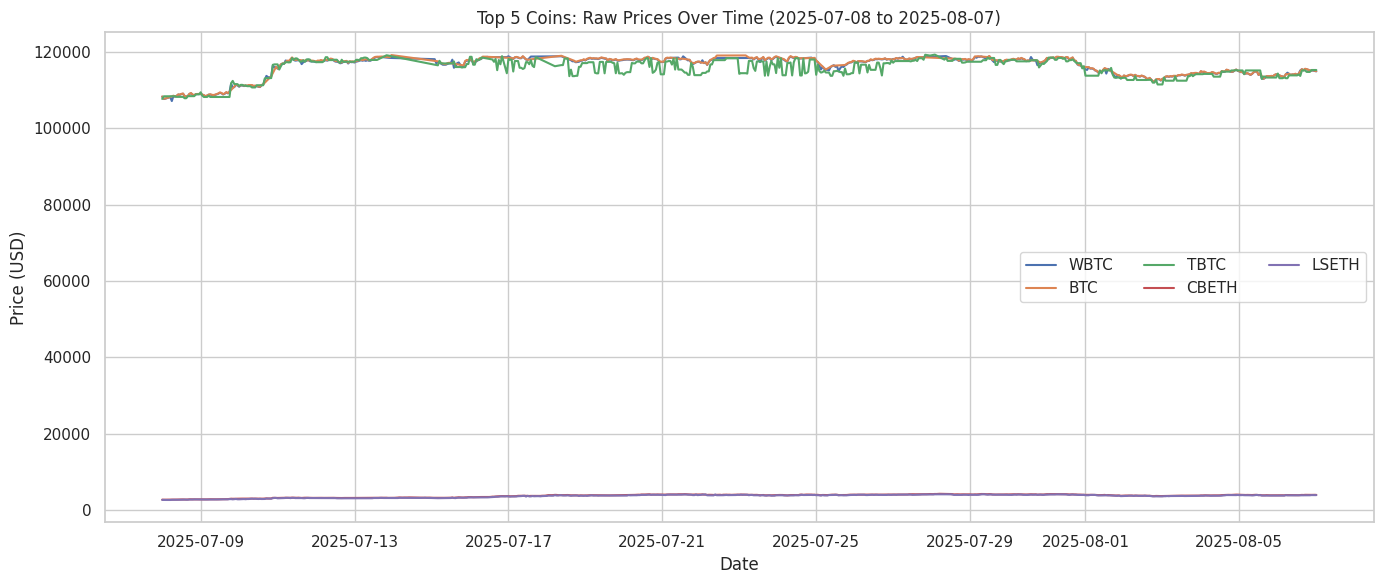

In [21]:
sns.set(style = 'whitegrid')

# Plot Top 5 coins raw prices
sub_top = df_range[df_range['coin'].isin(coins_top5)].copy()
sub_top = sub_top.sort_values('timestamp')
plt.figure(figsize = (14, 6))
for c in coins_top5:
    d = sub_top[sub_top['coin'] == c]
    plt.plot(d['timestamp'], d['price'], label = c, linewidth = 1.5)
plt.title('Top 5 Coins: Raw Prices Over Time (2025-07-08 to 2025-08-07)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(ncol = 3)
plt.tight_layout()
plt.savefig('Top 5 coins.png', dpi=300, bbox_inches='tight')
plt.show()

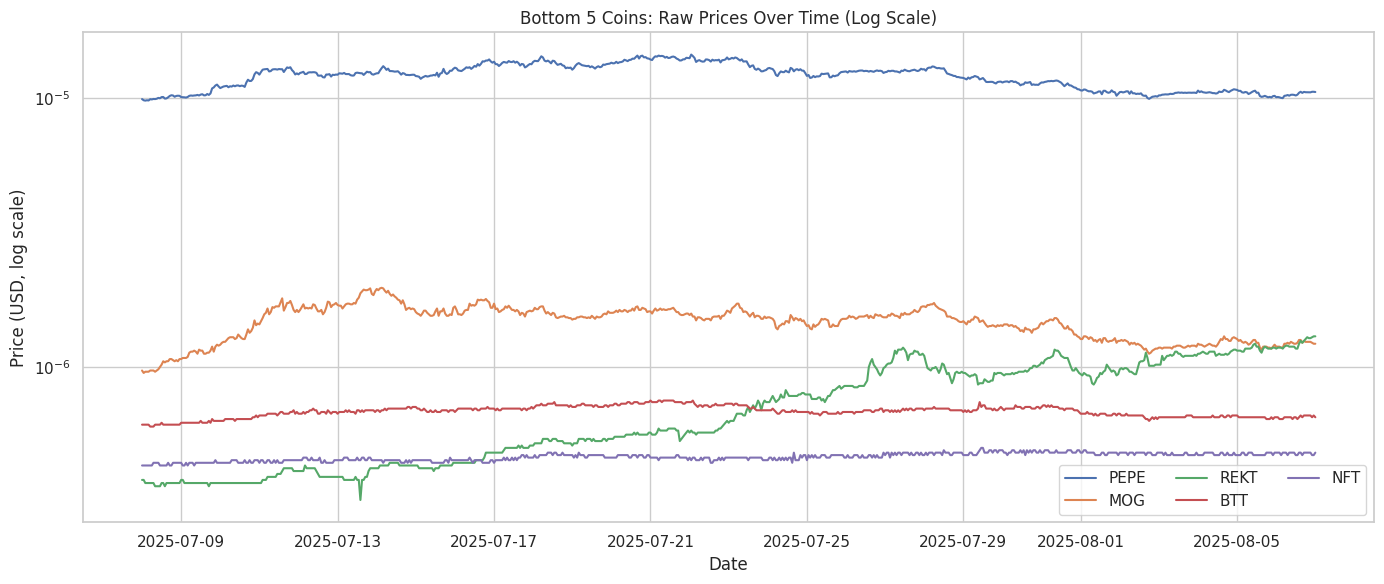

Generated insights and plotted raw price time series for Top 5 and Bottom 5 coins.


In [22]:
# Plot Bottom 5 coins raw prices (may need log scale if prices are tiny)
sub_bot = df_range[df_range['coin'].isin(coins_bottom5)].copy()
sub_bot = sub_bot.sort_values('timestamp')
plt.figure(figsize = (14, 6))
for c in coins_bottom5:
    d = sub_bot[sub_bot['coin'] == c]
    plt.plot(d['timestamp'], d['price'], label = c, linewidth = 1.5)
plt.yscale('log')
plt.title('Bottom 5 Coins: Raw Prices Over Time (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Price (USD, log scale)')
plt.legend(ncol = 3)
plt.tight_layout()
plt.savefig('Bottom 5 coins.png', dpi=300, bbox_inches='tight')
plt.show()

print('Generated insights and plotted raw price time series for Top 5 and Bottom 5 coins.')

In [23]:
# weekly trends

# Set week boundaries (Mon-Sun)

df['week'] = df['timestamp'].dt.to_period('W-SUN')

In [24]:
# For each coin and week, take first and last observed prices to compute weekly pct change

weekly = df.sort_values('timestamp').groupby(['coin', 'week']).agg(
    first_price = ('price', 'first'),
    last_price = ('price', 'last')
).reset_index()
weekly['pct_change'] = (weekly['last_price'] - weekly['first_price']) / weekly['first_price']
weekly['week_start'] = weekly['week'].dt.start_time

In [25]:
# Subsets for plotting

weekly_top = weekly[weekly['coin'].isin(top_5)].copy()
weekly_bot = weekly[weekly['coin'].isin(bottom_5)].copy()

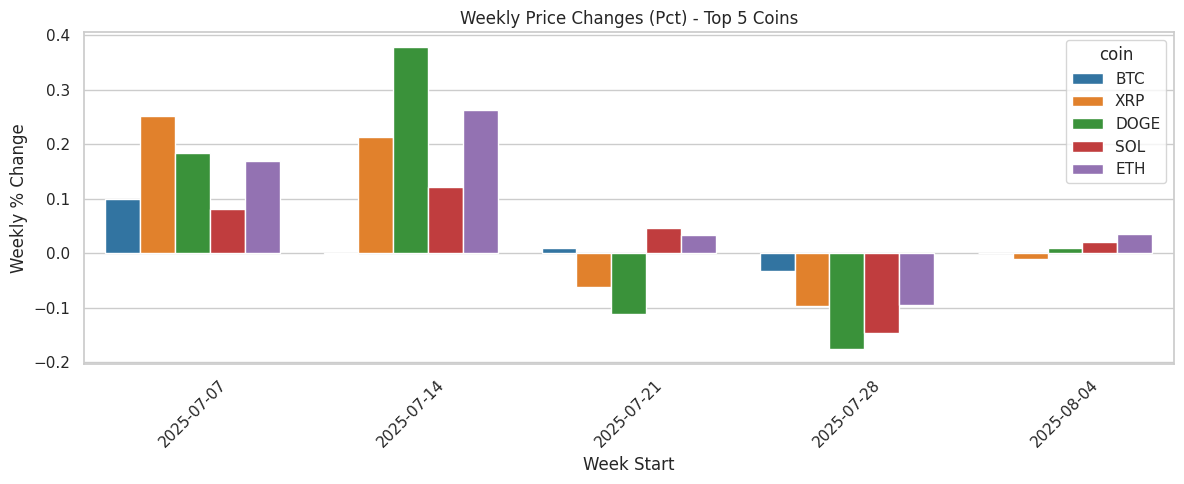

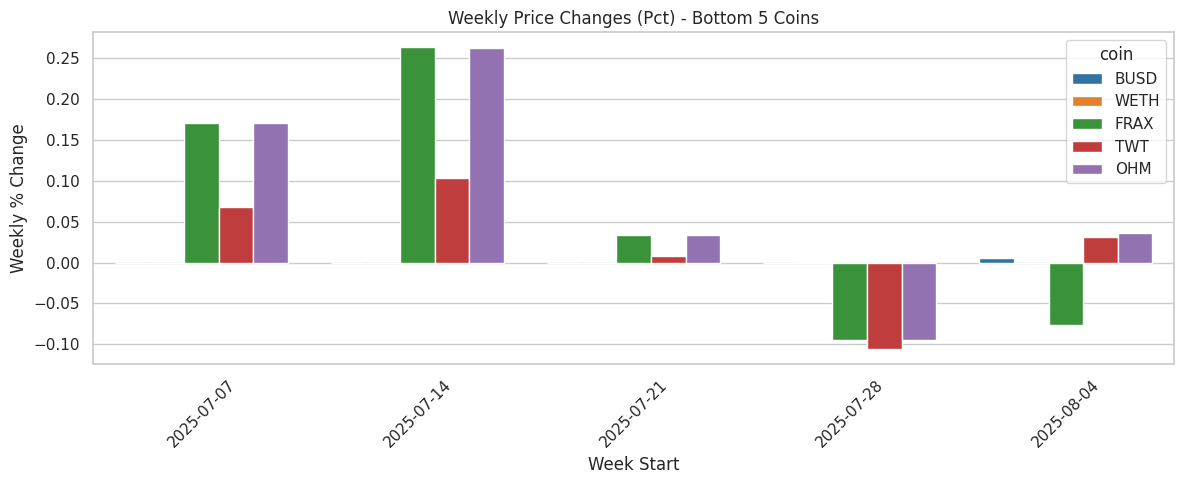

In [26]:
# Plot weekly pct changes as barplots 

sns.set(style = 'whitegrid')
plt.figure(figsize = (12, 5))
sns.barplot(data = weekly_top.sort_values('week_start'), x = 'week_start', y = 'pct_change', hue = 'coin', palette = 'tab10')
plt.title('Weekly Price Changes (Pct) - Top 5 Coins')
plt.xlabel('Week Start')
plt.ylabel('Weekly % Change')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('weekly Top 5.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize = (12, 5))
sns.barplot(data = weekly_bot.sort_values('week_start'), x = 'week_start', y = 'pct_change', hue = 'coin', palette = 'tab10')
plt.title('Weekly Price Changes (Pct) - Bottom 5 Coins')
plt.xlabel('Week Start')
plt.ylabel('Weekly % Change')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('weekly Bottom 5.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Summary tables: best and worst weekly movers overall

best_weeks = weekly.sort_values('pct_change', ascending = False).head(5)[['coin','week_start','pct_change']]
worst_weeks = weekly.sort_values('pct_change').head(5)[['coin','week_start','pct_change']]
print('Top 5 weekly gains:')
print(best_weeks)
print('Top 5 weekly losses:')
print(worst_weeks)

print('Computed weekly price changes and plotted bar charts for Top 5 and Bottom 5 coins.')

Top 5 weekly gains:
      coin week_start  pct_change
96       B 2025-07-14         inf
801   USDF 2025-07-14         inf
586   PUMP 2025-07-14         inf
176    CFX 2025-07-14    1.176241
560  PENGU 2025-07-07    1.023601
Top 5 weekly losses:
         coin week_start  pct_change
743       TKX 2025-07-28   -0.483109
741       TKX 2025-07-14   -0.460087
587      PUMP 2025-07-21   -0.380179
298  FARTCOIN 2025-07-28   -0.321580
228      DEEP 2025-07-28   -0.303308
Computed weekly price changes and plotted bar charts for Top 5 and Bottom 5 coins.


## 2. Which coins have the most consistent (stable) vs. volatile price movements?

In [28]:
df['date'] = df['timestamp'].dt.date
df['date'] = pd.to_datetime(df['date'])

In [29]:
df['date'] = df['timestamp'].dt.floor('D')

agg_map = {
'open': 'first',
'high': 'max',
'low': 'min',
'price': 'last',
'volume': 'sum',
'market_cap': 'last',
'circulating_supply': 'last'
}
daily = df.sort_values(['coin','timestamp']).groupby(['coin','date'], as_index=False).agg(agg_map)
daily = daily.rename(columns={'price':'close'})
print('Aggregated intraday to daily OHLCV')

Aggregated intraday to daily OHLCV


In [30]:
# Compute daily metrics

daily = daily.sort_values(['coin','date'])
daily['ret'] = daily.groupby('coin')['close'].pct_change()

In [31]:
# Realized volatility: rolling window (uses daily returns), annualized by sqrt(365)

daily['rv_7d'] = daily.groupby('coin')['ret'].rolling(window=7).std().reset_index(level=0, drop=True) * np.sqrt(365)
daily['rv_30d'] = daily.groupby('coin')['ret'].rolling(window=30).std().reset_index(level=0, drop=True) * np.sqrt(365)

In [32]:
# Daily range

daily['range_abs'] = daily['high'] - daily['low']
daily['range_pct'] = np.where(daily['low'] != 0, (daily['high'] - daily['low']) / daily['low'], np.nan)
print('Computed returns, rolling vol (7D/30D), and range metrics')

Computed returns, rolling vol (7D/30D), and range metrics


In [33]:
# Identify bottom 5 (stable) and top 5 (volatile)

bottom_5 = coin_vol.head(5).copy()
top_5 = coin_vol.tail(5).copy()


daily.to_csv('daily_volatility_metrics.csv', index = False)
coin_vol.to_csv('coin_volatility_ranking.csv', index = False)

print('Saved daily_volatility_metrics.csv and coin_volatility_ranking.csv')

NameError: name 'coin_vol' is not defined

In [ ]:
# Tag groups and produce comparison KDE of 30D vol

stable_set = set(bottom_5['coin'].tolist())
volatile_set = set(top_5['coin'].tolist())

daily['group'] = np.where( daily['coin'].isin(stable_set),'Stable_Bottom5', np.where(daily['coin'].isin(volatile_set),'Volatile_Top5','Other'))

In [ ]:
# Rank coins by average 30D realized volatility

coin_vol = daily.groupby('coin', as_index=False)['rv_30d'].mean().rename(columns={'rv_30d':'avg_rv_30d'})
coin_vol = coin_vol.sort_values('avg_rv_30d')
bottom_5 = coin_vol.head(5).copy()
top_5 = coin_vol.tail(5).copy()

stable_set = set(bottom_5['coin'].tolist())
volatile_set = set(top_5['coin'].tolist())
daily['group'] = np.where(daily['coin'].isin(stable_set), 'Stable_Bottom5',
np.where(daily['coin'].isin(volatile_set), 'Volatile_Top5', 'Other'))
print('Identified Top5 most volatile and Bottom5 most stable coins')

In [ ]:
daily.to_csv('daily_volatility_metrics.csv', index=False)
coin_vol.to_csv('coin_volatility_ranking.csv', index=False)
print('Saved daily_volatility_metrics.csv and coin_volatility_ranking.csv')

In [ ]:
# Visuals

sns.set(style='whitegrid')

# KDE of 30D realized volatility for Top5 vs Bottom5

plt.figure(figsize=(9,5))
sns.kdeplot( data=daily[daily['group'] != 'Other'], x='rv_30d', hue='group', common_norm=False, fill=True, alpha=0.4)
plt.title('30D Realized Volatility: Top5 vs Bottom5')
plt.xlabel('30D realized volatility (annualized)')
plt.ylabel('Density')
plt.savefig('30 day density.png', dpi=300, bbox_inches='tight')
plt.show()
print('Plotted KDE for 30D realized volatility')

In [ ]:
# Boxplot distribution of 30D vol by coin for Top5/Bottom5

focus_coins = list(bottom_5) + list(top_5)

subset = daily[daily['coin'].isin(focus_coins)].copy()

plt.figure(figsize=(12,6))
sns.boxplot(data=subset, x='coin', y='rv_30d', hue='group')
plt.title('Distribution of 30D Volatility by Coin (Top5 vs Bottom5)')
plt.xlabel('Coin')
plt.ylabel('30D realized volatility (annualized)')
plt.xticks(rotation=45)
plt.savefig('30 day boxplt dist.png', dpi=300, bbox_inches='tight')
plt.show()
print('Plotted boxplot of 30D volatility by coin')

In [ ]:
# Day-of-week pattern for 7D volatility (Top5 vs Bottom5)

subset2 = daily[daily['group'] != 'Other'].copy()
subset2['dow'] = pd.to_datetime(subset2['date']).dt.weekday
pattern = subset2.groupby(['group','dow'], as_index=False)['rv_7d'].mean()

plt.figure(figsize=(9,5))
sns.lineplot(data=pattern, x='dow', y='rv_7d', hue='group', marker='o')
plt.title('Average 7D Volatility by Day of Week')
plt.xlabel('Day of Week (0=Mon)')
plt.ylabel('Avg 7D realized volatility (annualized)')
plt.savefig('Average 7D Volatility by Day of Week.png', dpi=300, bbox_inches='tight')
plt.show()
print('Plotted day-of-week volatility pattern')

In [ ]:
pattern.to_csv('dow_volatility_pattern.csv', index=False)
print('Saved dow_volatility_pattern.csv')

## 3. Do price spikes cluster at certain times (e.g., UTC hours or day boundaries)?

In [53]:
# Ensure uniform frequency per coin by resampling to hourly 
# We compute hourly OHLCV per coin.

def to_hourly(dfc):
    dfc = dfc.set_index('timestamp')
    ohlc = dfc.resample('1h').agg({
        'price': 'last',
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'volume': 'sum',
        'market_cap': 'last',
        'circulating_supply': 'last'
    })
    ohlc = ohlc.dropna(subset = ['price'])
    ohlc = ohlc.reset_index()
    return ohlc

hourly_list = []
for coin, g in df.groupby('coin'):
    g2 = g[['timestamp','price','open','high','low','volume','market_cap','circulating_supply']].copy()
    H = to_hourly(g2)
    H['coin'] = coin
    hourly_list.append(H)

hourly = pd.concat(hourly_list, ignore_index = True)
hourly = hourly.sort_values(['coin','timestamp']).reset_index(drop = True)
print('Aggregated to hourly OHLCV per coin')

Aggregated to hourly OHLCV per coin


In [54]:
# Compute returns and realized volatility proxies

hourly['ret'] = hourly.groupby('coin')['price'].pct_change()
hourly['abs_ret'] = hourly['ret'].abs()

In [55]:
# Rolling realized vol (hourly): 24h and 7d windows

hourly['rv_24h'] = hourly.groupby('coin')['ret'].rolling(window=24, min_periods=12).std().reset_index(level=0, drop=True) * np.sqrt(24*365)
hourly['rv_7d'] = hourly.groupby('coin')['ret'].rolling(window=24*7, min_periods=24).std().reset_index(level=0, drop=True) * np.sqrt(24*365)
print('Computed hourly returns and rolling volatility')


Computed hourly returns and rolling volatility


In [56]:
# Volume analysis (normalize volume)
# Volume z-score per coin to identify abnormal activity

hourly['vol_z'] = hourly.groupby('coin')['volume'].transform(lambda s: (s - s.mean()) / (s.std(ddof = 0) if s.std(ddof = 0) != 0 else 1.0))

In [57]:
# Volume percentile

hourly['vol_pct'] = hourly.groupby('coin')['volume'].transform(lambda s: s.rank(pct = True))
print('Computed volume z-scores and percentiles')

Computed volume z-scores and percentiles


In [58]:
# Spike detection
# Define a spike as large absolute return relative to coin's rolling median absolute deviation or std.
# We will use rolling robust z using median and MAD over 72 hours.

window = 72

def rolling_mad(x):
    med = x.median()
    mad = (x - med).abs().median()
    if mad == 0 or np.isnan(mad):
        return 0.0
    return (x.iloc[-1] - med) / (1.4826 * mad)

In [59]:
# Compute rolling robust z for abs_ret per coin

hourly['robust_z'] = np.nan

for coin, g in hourly.groupby('coin'):
    vals = g['abs_ret'].fillna(0.0)
    rz = []
    for i in range(len(vals)):
        start = max(0, i - window + 1)
        segment = vals.iloc[start:i+1]
        med = segment.median()
        mad = (segment - med).abs().median()
        if mad == 0 or np.isnan(mad):
            rz.append(np.nan)
        else:
            rz.append((segment.iloc[-1] - med) / (1.4826 * mad))
    hourly.loc[g.index, 'robust_z'] = rz
print('Computed rolling robust z for spike detection')

Computed rolling robust z for spike detection


In [60]:
# Flag spikes using thresholds on robust_z and absolute return

abs_ret_thr = hourly['abs_ret'].quantile(0.99)
z_thr = 3.5
hourly['is_spike'] = (hourly['robust_z'] >= z_thr) & (hourly['abs_ret'] >= abs_ret_thr)
print('Flagged spikes using robust z >= 3.5 and top 1 percent absolute returns')

Flagged spikes using robust z >= 3.5 and top 1 percent absolute returns


In [62]:
#  Spike magnitudes and direction

hourly['spike_magnitude_pct'] = np.where(hourly['is_spike'], hourly['ret'] * 100.0, np.nan)
hourly['spike_direction'] = np.where(hourly['is_spike'], np.where(hourly['ret'] >= 0, 'Up', 'Down'), None).astype('object')
print('Computed spike magnitudes and directions')


Computed spike magnitudes and directions


In [63]:
# Time categories (hour of day, day of week, weekend vs weekday, session buckets UTC)

hourly['hour'] = hourly['timestamp'].dt.hour
hourly['dow'] = hourly['timestamp'].dt.weekday
hourly['is_weekend'] = hourly['dow'].isin([5,6])

# Session buckets (UTC): Asia 0-7, Europe 7-14, US 14-21, Other 21-24
bins = [0,7,14,21,24]
labels = ['Asia','Europe','US','Other']
hourly['session'] = pd.cut(hourly['hour'].replace(24,0), bins = bins, labels = labels, right = False, include_lowest = True)
print('Derived time categories')


Derived time categories


In [147]:
# Hourly spikes summary by coin

spikes = hourly[hourly['is_spike']].copy()
coin_summary = spikes.groupby('coin').agg(
    spikes_count = ('is_spike','sum'),
    pct_up = ('spike_direction', lambda s: np.mean(s == 'Up') if len(s) > 0 else np.nan),
    median_mag_pct = ('spike_magnitude_pct','median'),
    mean_mag_pct = ('spike_magnitude_pct','mean'),
    median_vol_z = ('vol_z','median')
).reset_index()

print('Spike coin-level summary (head)')
print(coin_summary.head())
print('Spike coin-level summary (tail)')
print(coin_summary.tail())

Spike coin-level summary (head)
    coin  spikes_count    pct_up  median_mag_pct  mean_mag_pct  median_vol_z
0  1INCH             7  0.857143        4.591658      4.058633      2.558925
1      A             3  0.666667        6.468350      3.025552      0.729642
2    ADA             1  1.000000        4.158560      4.158560      4.973637
3   AERO             4  0.750000        4.626098      2.454742      5.344721
4   AIOZ             2  0.500000        0.482756      0.482756      4.795221
Spike coin-level summary (tail)
     coin  spikes_count    pct_up  median_mag_pct  mean_mag_pct  median_vol_z
122   XLM            11  0.909091        4.578532      4.779510      2.203274
123   XTZ            11  0.727273        5.888377      5.188621      2.035536
124  ZBCN            26  0.769231        5.475425      3.332368      0.478347
125   ZEC             1  0.000000       -6.347032     -6.347032      8.737360
126    ZK             4  1.000000        4.496255      4.434723      2.565407


In [149]:
# Time-of-day and day-of-week patterns

hourly_pattern = spikes.groupby('hour').agg(
    spikes = ('is_spike','sum'),
    median_mag_pct = ('spike_magnitude_pct','median')
).reset_index()

dow_pattern = spikes.groupby('dow').agg(
    spikes = ('is_spike','sum'),
    median_mag_pct = ('spike_magnitude_pct','median')
).reset_index()

session_pattern = spikes.groupby('session').agg(
    spikes = ('is_spike','sum'),
    median_mag_pct = ('spike_magnitude_pct','median')
).reset_index()

print('Computed time-of-day and day-of-week spike patterns')
print(hourly_pattern.head(24))
print(dow_pattern.head(24))
print(session_pattern.head(24))

Computed time-of-day and day-of-week spike patterns
    hour  spikes  median_mag_pct
0      0      36        4.429036
1      1      30        4.710677
2      2      30        5.490768
3      3      36        4.590060
4      4      36        4.590770
5      5      42       -4.049879
6      6      29        4.908377
7      7      14        5.097343
8      8      27        4.734848
9      9      27        5.906736
10    10      24       -4.755684
11    11      32        5.082736
12    12      34        4.349309
13    13      35        4.774898
14    14      87        4.402095
15    15      42        4.142459
16    16      49        4.406780
17    17      32        4.261473
18    18      26        5.681332
19    19      29        4.559707
20    20      19       -4.066233
21    21      54        4.957822
22    22      19       -4.521414
23    23      13        4.925210
   dow  spikes  median_mag_pct
0    0     106        4.784964
1    1     146        4.290368
2    2     112        4.536792

/tmp/ipykernel_24722/2007734762.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_pattern = spikes.groupby('session').agg(


In [66]:
# Volume conditioning: spikes when volume z is extreme

spikes['high_vol'] = spikes['vol_z'] >= 2.0
vol_conditioning = spikes.groupby('high_vol').agg(
    spikes = ('is_spike','sum'),
    median_mag_pct = ('spike_magnitude_pct','median')
).reset_index()
print('Computed volume conditioning for spikes')
print(vol_conditioning)

Computed volume conditioning for spikes
   high_vol  spikes  median_mag_pct
0     False     520        4.391556
1      True     282        4.726941


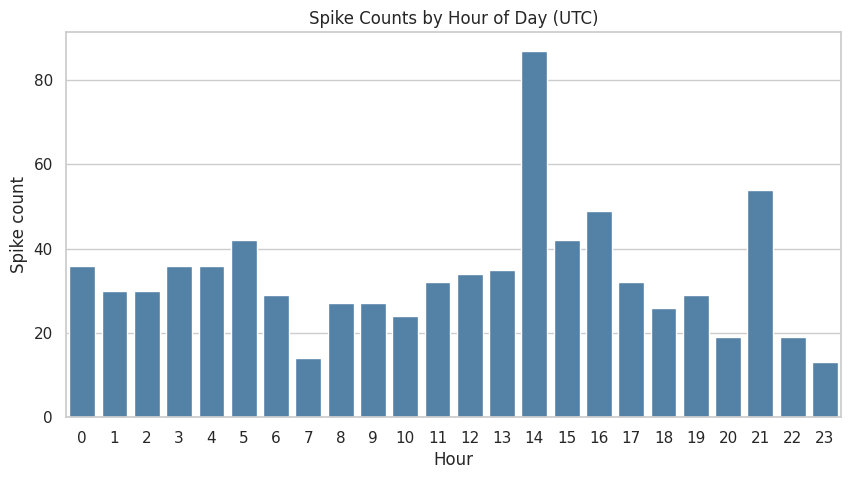

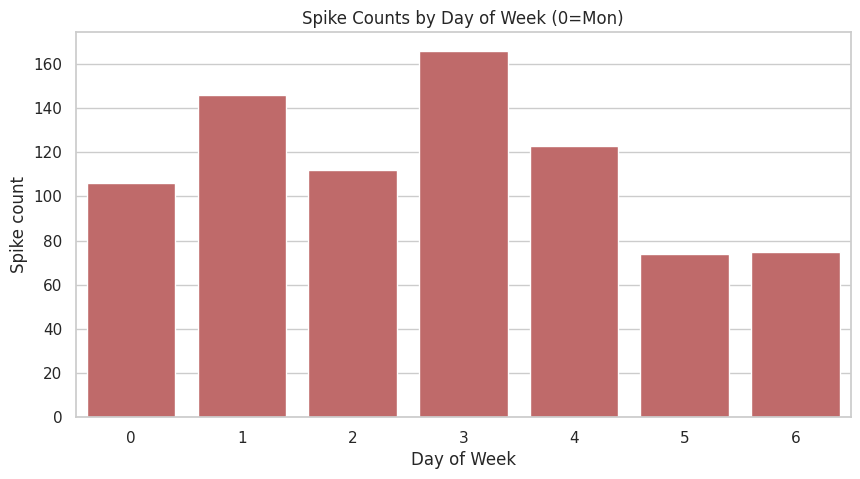

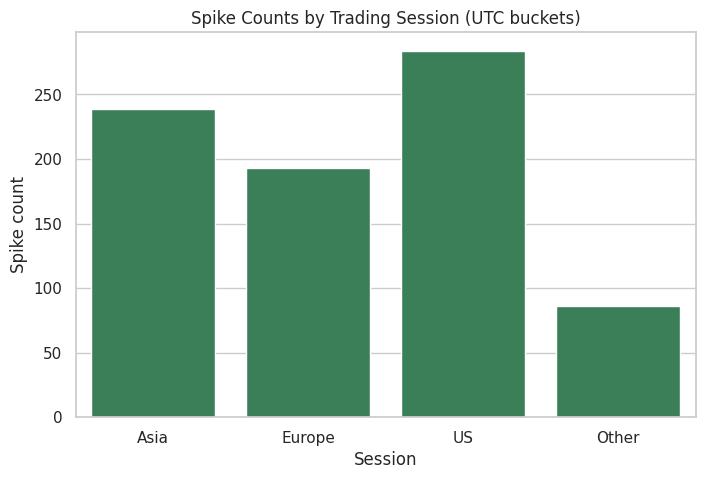

In [146]:
# Visualizations 

plt.figure(figsize=(10,5))
sns.barplot(data=hourly_pattern, x='hour', y='spikes', color='steelblue')
plt.title('Spike Counts by Hour of Day (UTC)')
plt.xlabel('Hour')
plt.ylabel('Spike count')
plt.savefig('Spike Count by hour of day.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=dow_pattern, x='dow', y='spikes', color='indianred')
plt.title('Spike Counts by Day of Week (0=Mon)')
plt.xlabel('Day of Week')
plt.ylabel('Spike count')
plt.savefig('Spike count by day of week.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=session_pattern, x='session', y='spikes', color='seagreen')
plt.title('Spike Counts by Trading Session (UTC buckets)')
plt.xlabel('Session')
plt.ylabel('Spike count')
plt.savefig('Spike count by trading session.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
hourly.to_csv('hourly_with_spikes.csv', index=False)
spikes.to_csv('spike_events.csv', index=False)
coin_summary.to_csv('spike_coin_summary.csv', index=False)
hourly_pattern.to_csv('spike_hour_pattern.csv', index=False)
dow_pattern.to_csv('spike_dow_pattern.csv', index=False)
session_pattern.to_csv('spike_session_pattern.csv', index=False)
vol_conditioning.to_csv('spike_volume_conditioning.csv', index=False)
print('Saved hourly_with_spikes.csv, spike_events.csv, spike_coin_summary.csv, spike_hour_pattern.csv, spike_dow_pattern.csv, spike_session_pattern.csv, spike_volume_conditioning.csv')

Saved hourly_with_spikes.csv, spike_events.csv, spike_coin_summary.csv, spike_hour_pattern.csv, spike_dow_pattern.csv, spike_session_pattern.csv, spike_volume_conditioning.csv
